In [26]:
using Revise
using FinalProject
using Plots

## Load the data

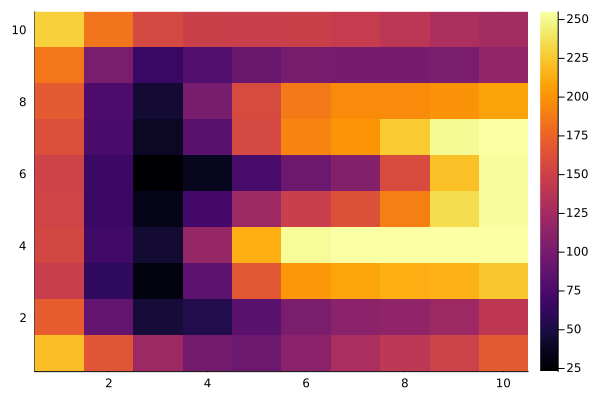

In [32]:
labels, images = get_data("../data/data_alphabet.npz")
r = images[:,:,labels .== 0x04]
Plots.heatmap(reverse(r[:,:,6], dims=1))

## Chose two letters & create train and test sets

(3, 30)


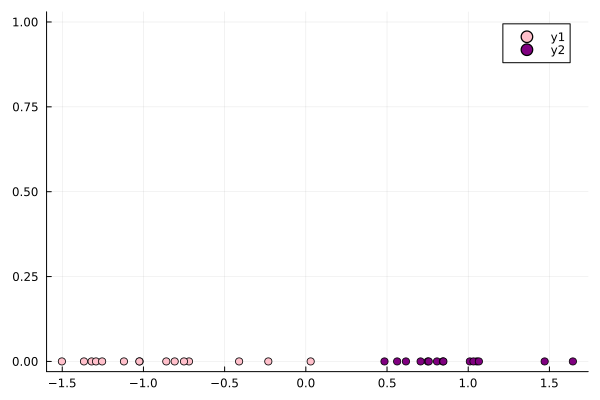

In [11]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V',
'Y', 'Z']
imgs, lbls, letter_counts = create_work_set(alphabet, images, labels, letters = "CN");
imgs_trn, lbls_trn, imgs_tst, lbls_tst = crossval(imgs, lbls, letter_counts);

# Create image features
method1 = LeftRight()
method2 = TopBottom()
x_trn = compute_measurements(imgs_trn, meas_type = method1)
y_trn = compute_measurements(imgs_trn, meas_type = method2)
x_tst = compute_measurements(imgs_tst, meas_type = method1)
y_tst = compute_measurements(imgs_tst, meas_type = method2)

# Create matrices of all the measurments
X_trn_2 = vcat(x_trn',y_trn')
X_trn_1 = reshape(x_trn, 1, size(x_trn)[1])
X_tst_2 = vcat(x_tst',y_tst')
X_tst_1 = reshape(x_tst, 1, size(x_tst)[1])

# Prepare the data
X_trn_1 = add_padding(X_trn_1, position="under")
X_trn_2 = add_padding(X_trn_2)
lbls_trn = flip_lbls(lbls_trn)
X_tst_1 = add_padding(X_tst_1, position="under")
X_tst_2 = add_padding(X_tst_2)
lbls_tst = flip_lbls(lbls_tst)

println(size(X_trn_2))

# Show data separability
x1 = x_trn[1:size(x_trn)[1]÷2]
x2 = x_trn[size(x_trn)[1]÷2+1:end]
plot(x1,zeros(15),seriestype=:scatter, color=:pink)
plot!(x2,zeros(15),seriestype=:scatter, color=:purple)

## Logistic regression

In [12]:
# Compute logistic loss and its gradient
X = [1 1 1 ; 1 2 3]
l = [1, -1, -1]
w = [1.5, -0.5]
println(logistic_loss(X,l,w))
logistic_loss_gradient(X,l,w)

0.6601619507527583


2×1 Matrix{Float64}:
 0.28450596994395316
 0.8253257470112381

Find the weights w with gradient descent

In [13]:
w_init = [-7.0,2.0,-8.0]
res = logistic_loss(X_trn_2,lbls_trn,w_init)
w,wt,Et = logistic_loss_gradient_descent(X_trn_2,lbls_trn,w_init)
res_lbl = classification(X_tst_2, w, "logreg")
err = compute_error(res_lbl, lbls_tst)
println("Classification error on the test set: $(err)")

Classification error on the test set: 0.1


Plot the progress of the gradient descent

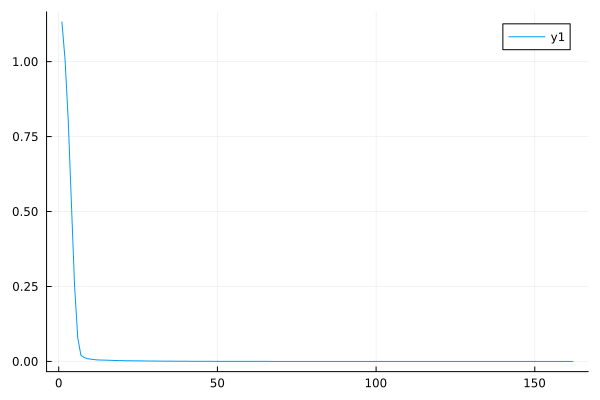

In [14]:
xs = 1:size(Et)[1]
plot(xs,Et)

Show test data separation

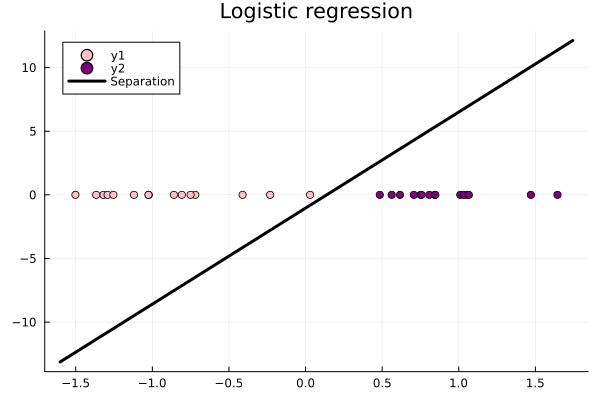

In [23]:
create_plot(x_trn, w, 3, "Logistic regression")


## Kozinec algorithm

In [16]:
# Arbitrary data
X = [3 4 5 -1 -1.5 -3 ; 1 0 1 -2 -1 -1.5]
y = [1,1,1,0,0,0]
X_n = add_padding(X)
y_n = flip_lbls(y)
alpha_k = kozinec(X_n,y_n)
alpha_p = kozinec(X_n,y_n,alg = Perceptron())
println(alpha_k)
println(alpha_p)

[3.0, 1.0, 1.0]
[3.0, 1.0, 1.0]


Classify test data

In [17]:
alpha_k = kozinec(X_trn_1, lbls_trn)
res_koz = classification(X_tst_1, alpha_k,"kozinec")
alpha_p = kozinec(X_trn_1, lbls_trn, alg=Perceptron())
res_per = classification(X_tst_1, alpha_k,"kozinec")
err_k = compute_error(res_koz, lbls_tst)
err_p = compute_error(res_per, lbls_tst)
println(alpha_k)
println(alpha_p)
println("Kozinec algorithm classification error on test data: $(err_k)")
println("Perceptron algorithm classification error on test data: $(err_p)")

[-0.6348672451965663, 0.17171093212038535]
[-2.2283740990748253, 1.0]
Kozinec algorithm classification error on test data: 0.06666666666666667
Perceptron algorithm classification error on test data: 0.06666666666666667


Show test data separation

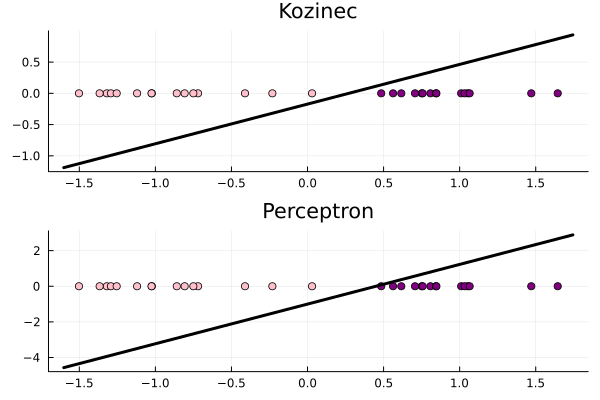

In [22]:
p1 = create_plot(x_trn, alpha_k,2, "Kozinec")
p2 = create_plot(x_trn, alpha_p,2, "Perceptron")
plot(p1, p2,layout=(2,1), legend=false)